In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 85)
sns.set_theme(context="paper", font_scale=1.5, style="ticks", rc={"axes.grid": True})

# Plot coefficients vs feature importance scores

#### Notebook summary

This notebook calculates the following
- Coefficients of logistic regression with no regularization, scaling, and PCA with no dropped components (within a pipeline)
- Feature importance scores of logistic regression with no regularization, with scaling and PCA with no dropped components (outside a pipeline)

The data used in these experiments:
- Two foundational features: occ_total_sum and oldest_phylostratum
- 80 confounder variables including trinucleotidic frequencies. 
- Dropped from ACC to UVM
- Dropped oldest_phylostratum_factor
- Dropped TTT_freq
- Dropped gc_cds
- Dropped NaNs

In the directory `./data/lr/` this notebook saves the following files:
- `lr_betas_and_scores.csv`

***
## Load the data

In [2]:
# Read Data from CSV (NEW DATA, NOT SCALED)
df = pd.read_csv("../data/abnormal_writeout_noscale.data.csv", index_col=0)

# trascurare da ACC a UVM
start_drop = df.columns.get_loc("ACC")
end_drop = df.columns.get_loc("UVM")
cols = np.arange(start_drop, end_drop + 1)
df.drop(df.columns[cols], axis=1, inplace=True)

# trascurare alcune colonne
df.drop("TTT_freq", axis=1, inplace=True) 
df.drop("oldest_phylostratum_factor", axis=1, inplace=True)
df.drop("gc_cds", axis=1, inplace=True) # ! New

# Drop NaNs
df.dropna(inplace=True)

# Sort features
resp = df["response"]
occ = df["occ_total_sum"]
age = df["oldest_phylostratum"]
conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1)

# Collect Features and Labels
features_df = pd.DataFrame()
features_df["occ_total_sum"] = occ
features_df["oldest_phylostratum"] = age
features_df = pd.concat([features_df, conf], axis=1)

X = features_df.to_numpy()
y = df["response"].to_numpy()

features_df.head(5)

,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

## Custom PCA

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class ConfounderPCA(BaseEstimator, TransformerMixin):
    """ 
    Custom PCA transformer for this dataset.
    Applies PCA only to the many collinear confounder 
    variables.
    
    cols - columns to which PCA will be applied.
    
    n_components - same as with the "vanilla" PCA. 
        If 0 < n_components < 1, select the number of 
        components such that the amount of variance that 
        needs to be explained is greater than the 
        percentage specified by n_components.
        
    apply_PCA - if false, simply returns the untransformed data.
    """

    def __init__(self, cols, n_components=None, apply_PCA=True):
        self.n_components = n_components
        self.apply_PCA = apply_PCA
        self.cols = cols
        if self.apply_PCA:
            self.pca = PCA(n_components=self.n_components)

    def fit(self, X, y=None):
        if self.apply_PCA:
            self.pca.fit(X[:, self.cols])
        return self

    def transform(self, X, y=None):
        if self.apply_PCA:
            X_pca = self.pca.transform(X[:, self.cols])
            return np.c_[X[:, :2], X_pca]
        else:
            return X

features_df.head(5)

,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("Training set shape:", X_train.shape, y_train.shape)
# print("Testing set shape:", X_test.shape, y_test.shape)

## Calculate Coefficients

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

In [6]:
# Define the model
lr_clf = Pipeline([
    # Scale
    ("scaler", StandardScaler()),
    # Then PCA to confounder, keeping all components
    ("pca", ConfounderPCA(n_components=None, cols=np.arange(2, X.shape[1]))),
    # Then fit the model
    ("lr", LogisticRegression(max_iter=2000, penalty='none')),
])

# Train the model
lr_clf.fit(X_train, y_train)

# Collect the coefficients into a pandas dataframe
coef_df = pd.DataFrame(lr_clf["lr"].coef_.T, columns=["Beta"])

# Give descriptive names
coef_df.rename(index={0 : "occ_total_sum", 1 : "oldest_phylostratum"}, inplace=True)
coef_df.rename(index=lambda s: s-1 if isinstance(s, int) else s, inplace=True)
coef_df.rename(index=lambda s: f"PC {s}" if isinstance(s, int) else s, inplace=True)

# Print the dataframe of coefficients
coef_df.head(10)

,Beta
occ_total_sum,0.350199
oldest_phylostratum,-0.224863
PC 1,0.024099
PC 2,-0.019979
PC 3,-0.077844
PC 4,0.083830
PC 5,-0.025191
PC 6,-0.077344
PC 7,0.033434
PC 8,0.045761


## Calculate Scores

In [7]:
# First, apply scaling and PCA
scaler = StandardScaler()
pca = ConfounderPCA(n_components=None, cols=np.arange(2, X.shape[1]))
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))

# Then, fit the model to the data
model = LogisticRegression(max_iter=2000, penalty='none')
model.fit(X_train_pca, y_train) 
    
# Finally, perform a permutation test 
X_test_pca = pca.fit_transform(scaler.fit_transform(X_test))
results = permutation_importance(model, X_test_pca, y_test, n_repeats=10, random_state=3, scoring='roc_auc', n_jobs=-1)  

scores_df = pd.DataFrame(results.importances_mean, columns=["Score"], index=coef_df.index)
scores_df.head(10)

,Score
occ_total_sum,0.050025
oldest_phylostratum,0.029586
PC 1,0.003402
PC 2,-0.001265
PC 3,0.001851
PC 4,0.001777
PC 5,-0.000202
PC 6,0.007934
PC 7,0.003669
PC 8,0.000671


In [8]:
output_df = coef_df
output_df["Score"] = scores_df["Score"]
output_df.to_csv("data/lr/lr_betas_and_scores.csv")
output_df.head(10)

,Beta,Score
occ_total_sum,0.350199,0.050025
oldest_phylostratum,-0.224863,0.029586
PC 1,0.024099,0.003402
PC 2,-0.019979,-0.001265
PC 3,-0.077844,0.001851
PC 4,0.083830,0.001777
PC 5,-0.025191,-0.000202
PC 6,-0.077344,0.007934
PC 7,0.033434,0.003669
PC 8,0.045761,0.000671


In [9]:
output_df.sort_values(by="Score", key=abs, ascending=False).head(15)

,Beta,Score
occ_total_sum,0.350199,0.050025
oldest_phylostratum,-0.224863,0.029586
PC 6,-0.077344,0.007934
PC 66,0.955807,-0.004349
PC 69,-1.465592,0.003785
PC 7,0.033434,0.003669
PC 1,0.024099,0.003402
PC 24,0.162100,0.002827
PC 15,0.089834,0.002738
PC 9,-0.168261,-0.002403


In [10]:
output_df.sort_values(by="Beta", key=abs, ascending=False).head(15)

,Beta,Score
PC 79,2.145719,0.000174
PC 70,1.921622,-0.000619
PC 77,1.671911,-0.000188
PC 69,-1.465592,0.003785
PC 73,-1.112878,0.001328
PC 71,-0.997969,-0.000616
PC 66,0.955807,-0.004349
PC 78,0.451184,0.000182
PC 74,-0.432668,-0.000198
PC 75,0.427499,0.000595


## Scatterplot

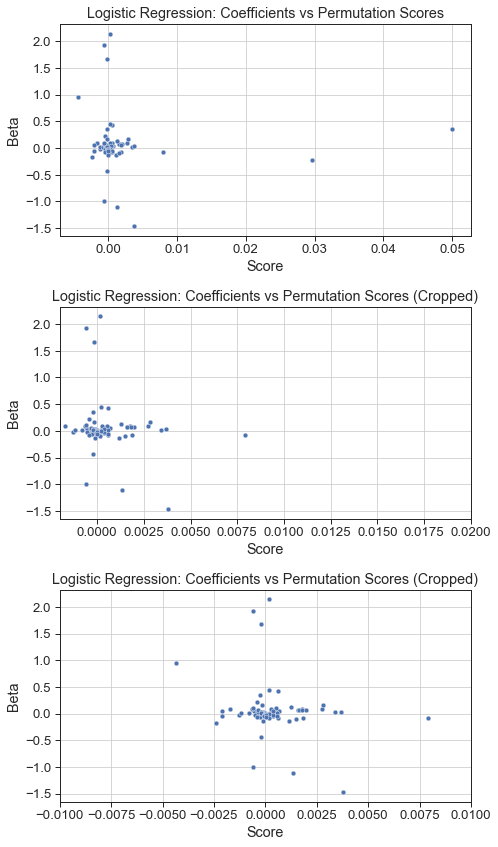

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(7,12))

sns.scatterplot(x=output_df["Score"], y=output_df["Beta"], ax=ax[0])
ax[0].title.set_text("Logistic Regression: Coefficients vs Permutation Scores")

sns.scatterplot(x=output_df["Score"], y=output_df["Beta"], ax=ax[1])
ax[1].title.set_text("Logistic Regression: Coefficients vs Permutation Scores (Cropped)")
ax[1].set_xlim(-0.002, 0.02)

sns.scatterplot(x=output_df["Score"], y=output_df["Beta"], ax=ax[2])
ax[2].title.set_text("Logistic Regression: Coefficients vs Permutation Scores (Cropped)")
ax[2].set_xlim(-0.01, 0.01)

plt.tight_layout()
plt.show()

In [12]:
from scipy.stats import spearmanr

spearmanr(output_df["Score"], output_df["Beta"])

SpearmanrResult(correlation=-0.038408376051632005, pvalue=0.7319071894523139)